## Import packages

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint
import time
import shap

#Metrics packages
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#Model split and scaling packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Model packages
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Model selection packages
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

## Data Pre-processing

In [3]:
raw_data = pd.read_csv('final_data4oct.csv') 
raw_data.head()

,Unnamed: 0,transcriptId,transcriptPosition,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0,ENST00000000233,244,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1
1,1,ENST00000000233,244,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9
2,2,ENST00000000233,244,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6
3,3,ENST00000000233,244,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4
4,4,ENST00000000233,244,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2


In [4]:
raw_info = pd.read_csv('data.info') # dataset containing labels and gene id
raw_info.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [5]:
raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
raw_data.rename(columns={'transcriptId': 'transcript_id', 'transcriptPosition': 'transcript_position'}, inplace=True)
raw_data.head()

,transcript_id,transcript_position,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,ENST00000000233,244,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1
1,ENST00000000233,244,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9
2,ENST00000000233,244,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6
3,ENST00000000233,244,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4
4,ENST00000000233,244,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2


In [6]:
# Group dataset by transcript id and position before meaning all 9 feature values
d = dict.fromkeys(('v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7','v8', 'v9'), ['mean'])
raw_data_grped = raw_data.groupby(['transcript_id', 'transcript_position']).agg(d)

# flatten MultiIndex columns
raw_data_grped.columns = ['_'.join(col) for col in raw_data_grped.columns.values]
raw_data_grped.head()

v1_mean   v2_mean     v3_mean   v4_mean  \
transcript_id   transcript_position                                             
ENST00000000233 244                  0.008264  4.223784  123.702703  0.009373   
                261                  0.006609  3.216424  109.681395  0.006813   
                316                  0.007570  2.940541  105.475676  0.007416   
                332                  0.010620  6.476350  129.355000  0.008632   
                368                  0.010701  6.415051  117.924242  0.011479   

                                      v5_mean     v6_mean   v7_mean   v8_mean  \
transcript_id   transcript_position                                             
ENST00000000233 244                  7.382162  125.913514  0.007345  4.386989   
                261                  3.226535  107.889535  0.007710  3.016599   
                316                  3.642703   98.947027  0.007555  2.087146   
                332                  2.899200   97.836500  0.006101  2.236520   
                368                  5.870303  121.954545  0.010019  4.260253   

                                       v9_mean  
transcript_id   transcript_position             
ENST00000000233 244                  80.570270  
                261                  94.290698  
                316                  89.364324  
                332                  89.154000  
                368                  85.178788

In [8]:
# concatenate mean dataset with data information, to include gene id and label as extra columns
df = pd.merge(raw_data_grped, raw_info, how = 'left', on = ['transcript_id', 'transcript_position'])
df.head()

,transcript_id,transcript_position,v1_mean,v2_mean,v3_mean,v4_mean,v5_mean,v6_mean,v7_mean,v8_mean,v9_mean,gene_id,label
0,ENST00000000233,244,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270,ENSG00000004059,0
1,ENST00000000233,261,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698,ENSG00000004059,0
2,ENST00000000233,316,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324,ENSG00000004059,0
3,ENST00000000233,332,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006101,2.236520,89.154000,ENSG00000004059,0
4,ENST00000000233,368,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788,ENSG00000004059,0


## Basic EDA

In [9]:
df.isnull().sum()

transcript_id          0
transcript_position    0
v1_mean                0
v2_mean                0
v3_mean                0
v4_mean                0
v5_mean                0
v6_mean                0
v7_mean                0
v8_mean                0
v9_mean                0
gene_id                0
label                  0
dtype: int64

In [10]:
df.dtypes

transcript_id           object
transcript_position      int64
v1_mean                float64
v2_mean                float64
v3_mean                float64
v4_mean                float64
v5_mean                float64
v6_mean                float64
v7_mean                float64
v8_mean                float64
v9_mean                float64
gene_id                 object
label                    int64
dtype: object

In [ ]:
df['label'].value_counts()

0    116363
1      5475
Name: label, dtype: int64

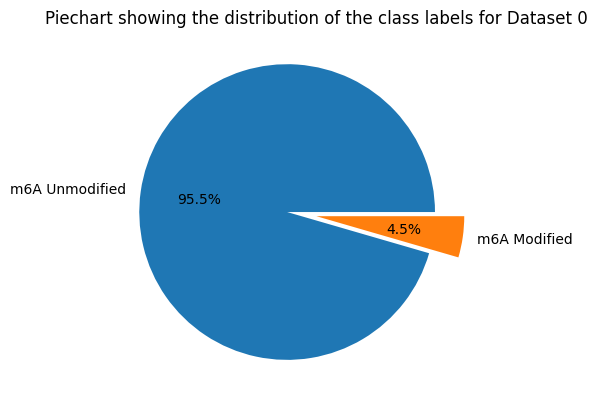

In [ ]:
y = np.array(df['label'].value_counts())
mylabels = ["m6A Unmodified","m6A Modified"]

plt.pie(y, labels = mylabels, explode =[0.2,0], autopct='%.1f%%')
plt.title('Piechart showing the distribution of the class labels for Dataset 0')
plt.show() 

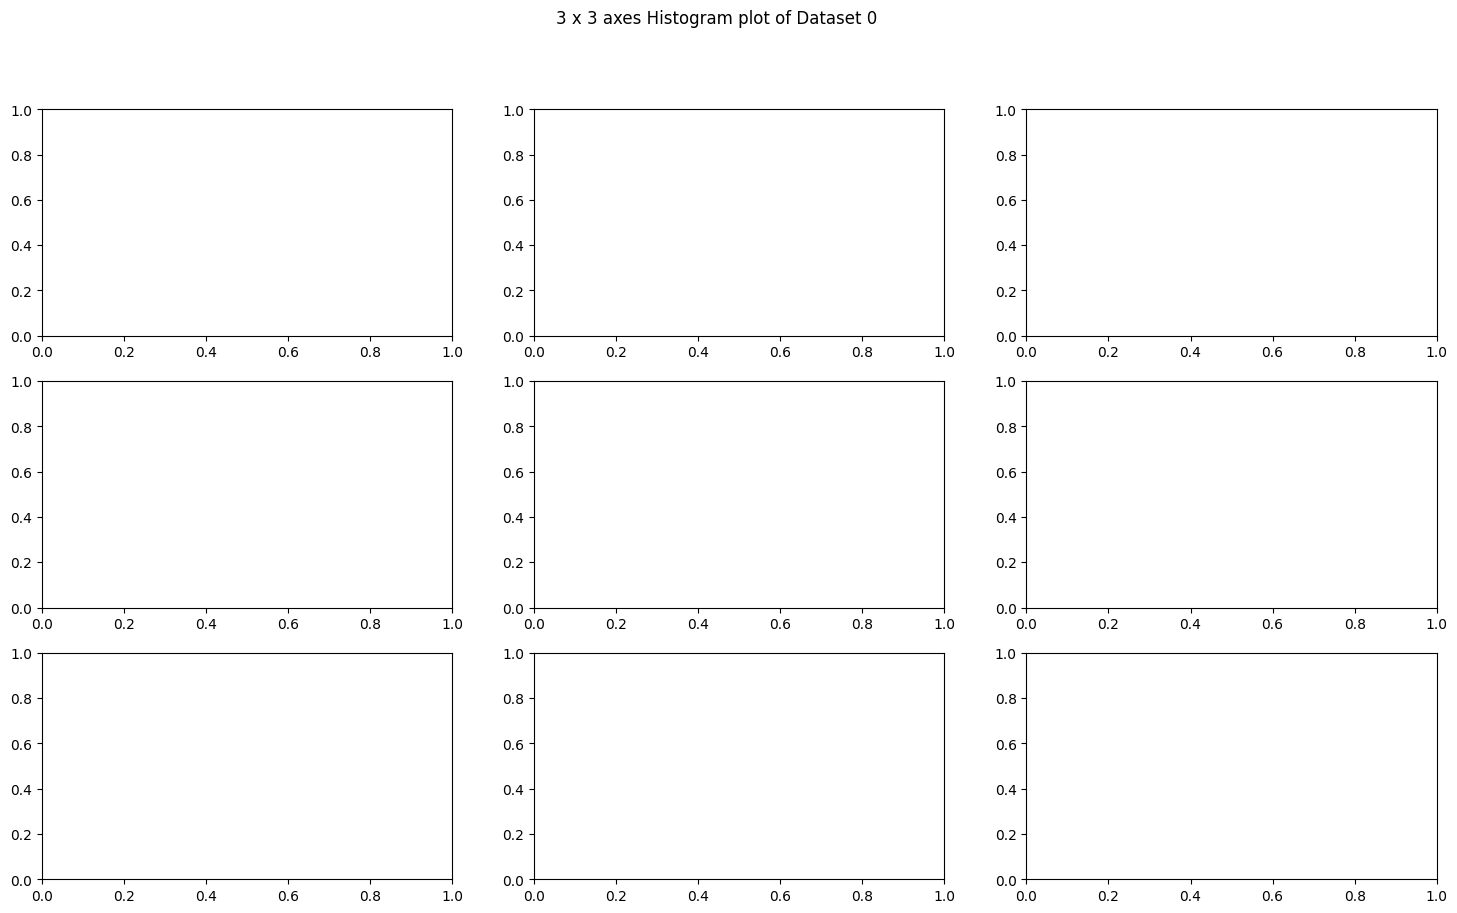

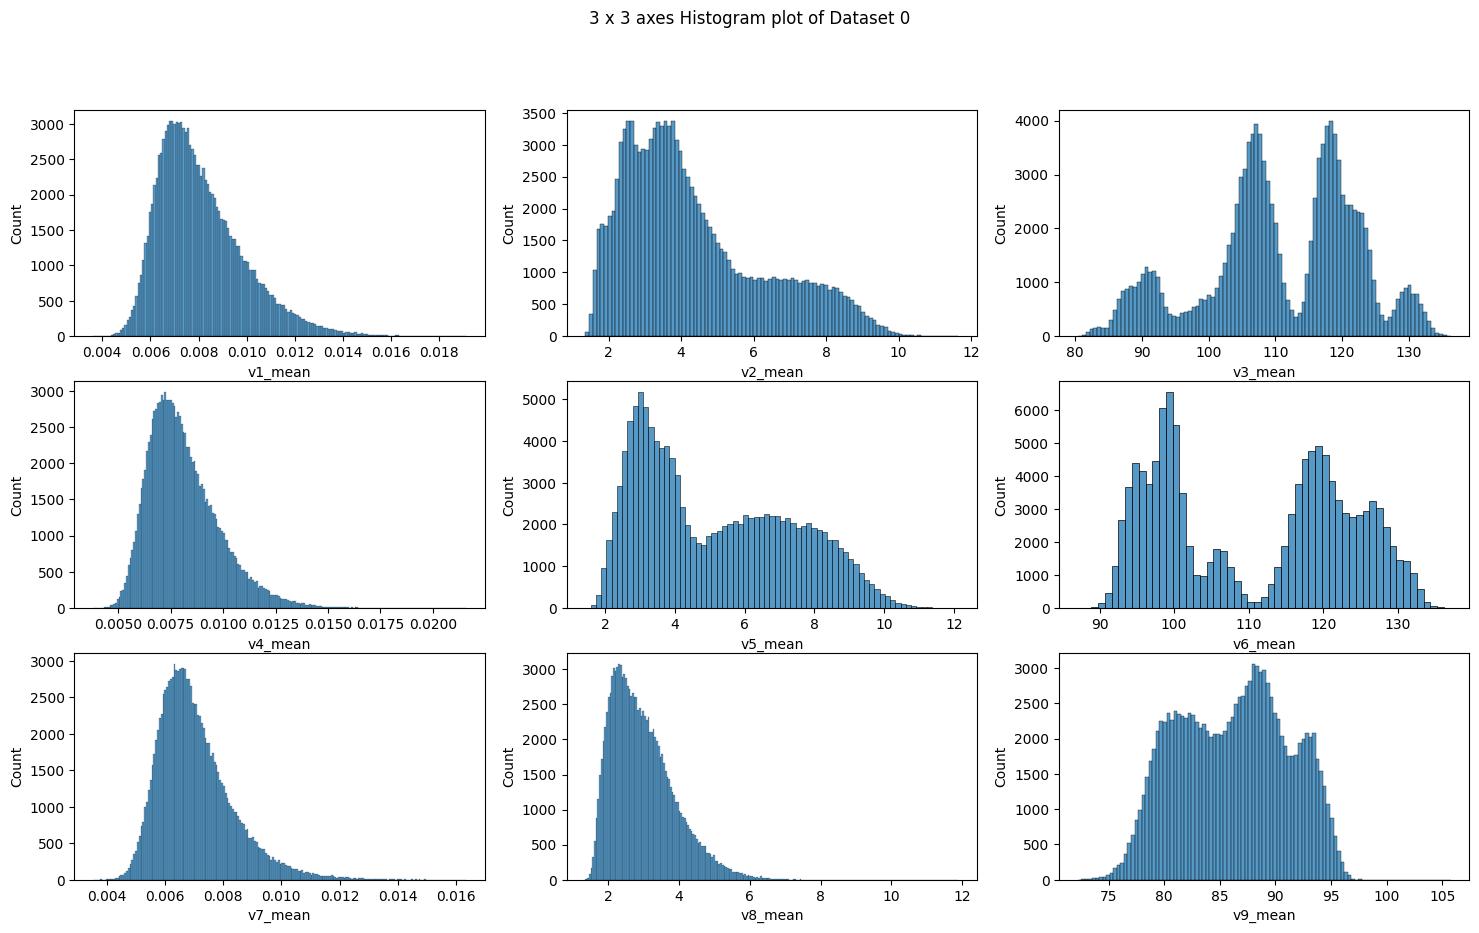

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
 
fig.suptitle('3 x 3 axes Histogram plot of Dataset 0')

sns.histplot(ax=axes[0, 0], data=df, x='v1_mean')
sns.histplot(ax=axes[0, 2], data=df, x='v3_mean')
sns.histplot(ax=axes[1, 0], data=df, x='v4_mean')
sns.histplot(ax=axes[0, 1], data=df, x='v2_mean')
sns.histplot(ax=axes[1, 1], data=df, x='v5_mean')
sns.histplot(ax=axes[1, 2], data=df, x='v6_mean')
sns.histplot(ax=axes[2, 0], data=df, x='v7_mean')
sns.histplot(ax=axes[2, 1], data=df, x='v8_mean')
sns.histplot(ax=axes[2, 2], data=df, x='v9_mean')
plt.show()

## Split train test dataset

In [10]:
final_df = df

In [11]:
scaler = StandardScaler() # standardize dataset
df1 = final_df.drop(['transcript_id', 'transcript_position', 'gene_id', 'label'], axis=1)
df2 = final_df[['transcript_id', 'transcript_position', 'gene_id', 'label']]
df_scaled = scaler.fit_transform(df1.to_numpy()) # only scale the 9 feature values
df_scaled = pd.DataFrame(df_scaled, columns=[
  'v1','v2','v3','v4', 'v5', 'v6', 'v7', 'v8', 'v9'])
final_data = pd.concat([df_scaled, df2], axis=1) # join features back with categorical variables
final_data

In [13]:
# split dataset by gene id to ensure that there is no overlapping genes between different splits
split_by_gene_id = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=25) # 20% test, 80% train
split = split_by_gene_id.split(final_data, groups=final_data['gene_id'])
train, val = next(split)

train_raw = final_data.iloc[train]
val_raw = final_data.iloc[val]

print(f"No. of training examples: {train_raw.shape}")
print(f"No. of testing examples: {val_raw.shape}")

No. of training examples: (98076, 13)
No. of testing examples: (23762, 13)


In [15]:
# removing columns that are not useful for my models
train_data = train_raw.drop(columns = ['transcript_id', 'transcript_position', 'gene_id'])
val_data = val_raw.drop(columns = ['transcript_id', 'transcript_position', 'gene_id'])

In [17]:
# split data into X and y
allcols = train_data.columns.tolist()
feature_cols = allcols.copy()
feature_cols.remove('label')
x_train = train_data[feature_cols] # Features
y_train = train_data['label'] # Labels

x_test = val_data[feature_cols]
y_test =val_data['label']

## XGBoost

In [ ]:
# XGBoost hyperparameter to curb imbalanced dataset
pos_weight = (len(y_train)-sum(y_train))/sum(y_train)
pos_weight

Basic XGBoost model with no parameter tuning

In [21]:
# No parameter tuning
clf = XGBClassifier(eval_metric="aucpr", scale_pos_weight = pos_weight,
        early_stopping_rounds=20)

clf.fit(x_train, y_train, 
        eval_set = [(x_test, y_test)], 
        verbose=False)

# Model evaluation
pred_prob_test = clf.predict_proba(x_test)[:,1] 
pred_value_test = clf.predict(x_test) 

print(classification_report(y_test, pred_value_test))

# ConfusionMatrixDisplay.from_predictions(y_test, pred_value_test)
plt.show()

auc = sklearn.metrics.roc_auc_score(y_test, pred_prob_test)
print('ROC AUC SCORE is: ', auc)

pr_auc = average_precision_score(y_test, pred_prob_test)
print("PR AUC SCORE is: " , pr_auc)

/opt/anaconda3/envs/DSA3101/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.98      0.89      0.93     22697
           1       0.22      0.67      0.33      1065

    accuracy                           0.88     23762
   macro avg       0.60      0.78      0.63     23762
weighted avg       0.95      0.88      0.91     23762

ROC AUC SCORE is:  0.8593671559249314
PR AUC SCORE is:  0.38497523468736033


Hyperparameter tuning

In [22]:
# Parameter tuning
params = {
        'clf__n_estimators': [i for i in range(100, 1000)],
        'clf__max_depth': [i for i in range(3, 10)],
        'clf__min_child_weight': [i for i in range(1, 10)],
        'clf__subsample': [i/100 for i in range(60, 100)],
        'clf__learning_rate': [i/1000.0 for i in range(100,1000,25)]
        }
clf = XGBClassifier(  
                    scale_pos_weight=22,
                    eval_metric="aucpr",
                    use_label_encoder=False  ## to remove warnings
                   )
folds = 15
param_comb = 15

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1002)


random_search = RandomizedSearchCV(clf, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring ='f1',
                                   n_jobs=4, 
                                   cv=skf.split(x_train,y_train), 
                                   verbose=3, 
                                  )

start_time = time.time()
random_search.fit(x_train, y_train)

print('\n Best estimator: ', random_search.best_estimator_)
print('\n Mean cross-validated score of the best_estimator for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_)
print('\n Best hyperparameters: ', random_search.best_params_)

print("The program runs for %s seconds" % (time.time() - start_time))

Fitting 15 folds for each of 15 candidates, totalling 225 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

Model with tuned hyperparameters

In [19]:
# the best parameters so far
clf = XGBClassifier(objective='binary:logistic', 
                        scale_pos_weight = 21.2,
                        clf_n_estimators=217, clf_max_depth=9,  clf_min_child_weight=2, 
                        clf_subsample=0.72, clf_learning_rate=0.825 ,
                        eval_metric="aucpr",
                        early_stopping_rounds=20)
clf.fit(x_train, y_train, 
        eval_set = [(x_test, y_test)], 
        verbose=False)

# Model evaluation
pred_prob_test = clf.predict_proba(x_test)[:,1] 
pred_value_test = clf.predict(x_test) 

print(classification_report(y_test, pred_value_test))

# ConfusionMatrixDisplay.from_predictions(y_test, pred_value_test)
plt.show()

auc = sklearn.metrics.roc_auc_score(y_test, pred_prob_test)
print('ROC AUC SCORE is: ', auc)

pr_auc = average_precision_score(y_test, pred_prob_test)
print("PR AUC SCORE is: " , pr_auc)


/opt/anaconda3/envs/DSA3101/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { clf_learning_rate, clf_max_depth, clf_min_child_weight, clf_n_estimators, clf_subsample, early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.98      0.89      0.93     22697
           1       0.23      0.69      0.34      1065

    accuracy                           0.88     23762
   macro avg       0.61      0.79      0.64     23762
weighted avg       0.95      0.88      0.91     23762

ROC AUC SCORE is:  0.8612531779654443
PR AUC SCORE is:  0.4055934406761154


Save trained model to import into AWS Ubuntu

In [20]:
clf.save_model("XGboostModel.json") 

XGBoost Feature Explainability

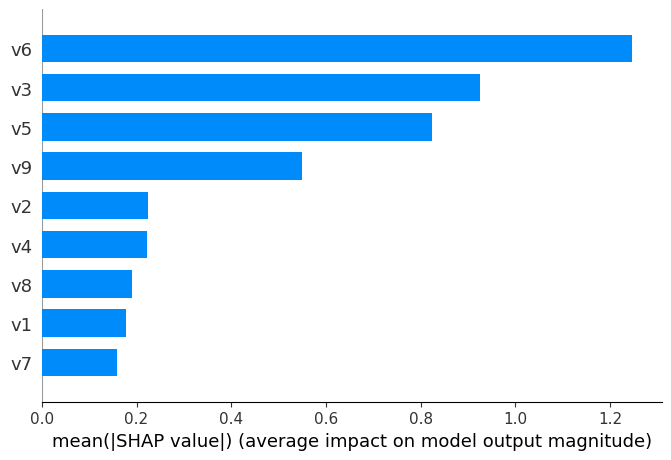

In [32]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

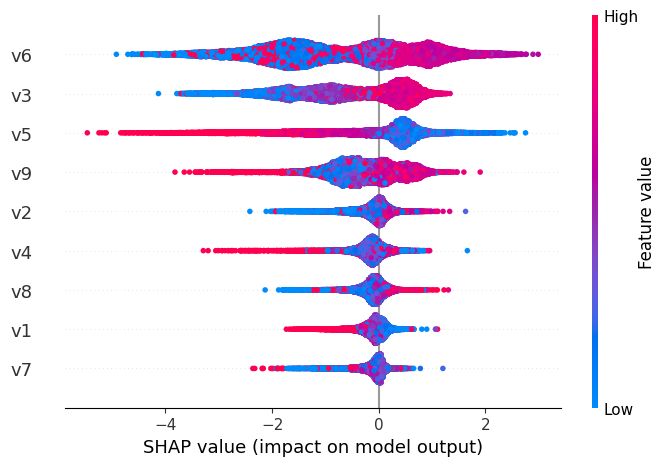

In [33]:
shap.summary_plot(shap_values, x_test)

# Task 1 and 2 Prediction tasks, raw data is ingested into Data Parsing notebook first

## For dataset0 prediction task

In [24]:
# Model evaluation
dataset0 = final_data.iloc[:,:9]
pred_prob_test = clf.predict_proba(dataset0)[:,1] # change x test to dataset1 and 2, finaldata without last 4 columns
pred_value_test = clf.predict(dataset0) 


In [25]:
dataset0_results = pd.concat([final_data.iloc[:,9:11], pd.DataFrame(pred_prob_test)], axis = 1)
dataset0_results = dataset0_results.rename(columns={0:'score'})
dataset0_results

,transcript_id,transcript_position,score
0,ENST00000000233,244,0.031141
1,ENST00000000233,261,0.104965
2,ENST00000000233,316,0.035501
3,ENST00000000233,332,0.117236
4,ENST00000000233,368,0.436630
...,...,...,...
121833,ENST00000641834,1348,0.962452
121834,ENST00000641834,1429,0.049917
121835,ENST00000641834,1531,0.950562
121836,ENST00000641834,1537,0.053338


In [26]:
dataset0_results.to_csv("jaly_dataset0_1.csv", index = False)

## For dataset1 prediction task

In [27]:
dataset1 = pd.read_csv("dataset1_converted.csv")
dataset1

,Unnamed: 0,transcriptId,transcriptPosition,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0,ENST00000000233,244,0.00465,2.16,127.0,0.00640,3.90,127.0,0.00797,8.75,83.7
1,1,ENST00000000233,244,0.02690,4.43,106.0,0.01860,10.00,123.0,0.00863,6.20,80.0
2,2,ENST00000000233,244,0.00432,3.10,108.0,0.01200,8.26,125.0,0.01590,2.89,78.7
3,3,ENST00000000233,244,0.00996,4.52,123.0,0.01750,8.51,128.0,0.00498,2.63,80.0
4,4,ENST00000000233,244,0.00764,2.81,124.0,0.00772,4.22,126.0,0.00474,5.84,80.9
...,...,...,...,...,...,...,...,...,...,...,...,...
7907947,7907947,ENST00000641784,3266,0.00589,1.20,93.5,0.00270,1.58,102.0,0.01530,2.19,92.3
7907948,7907948,ENST00000641784,3266,0.00401,2.00,92.1,0.00764,3.00,99.1,0.00469,1.37,92.6
7907949,7907949,ENST00000641784,3266,0.00430,1.32,91.8,0.00270,1.33,100.0,0.00550,1.37,93.9
7907950,7907950,ENST00000641784,3266,0.00280,2.70,90.7,0.00564,1.45,100.0,0.01600,1.90,92.3


In [28]:
dataset1= dataset1.drop(['Unnamed: 0'], axis=1)
dataset1.rename(columns={'transcriptId': 'transcript_id', 'transcriptPosition': 'transcript_position'}, inplace=True)
dataset1.head()

,transcript_id,transcript_position,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,ENST00000000233,244,0.00465,2.16,127.0,0.00640,3.90,127.0,0.00797,8.75,83.7
1,ENST00000000233,244,0.02690,4.43,106.0,0.01860,10.00,123.0,0.00863,6.20,80.0
2,ENST00000000233,244,0.00432,3.10,108.0,0.01200,8.26,125.0,0.01590,2.89,78.7
3,ENST00000000233,244,0.00996,4.52,123.0,0.01750,8.51,128.0,0.00498,2.63,80.0
4,ENST00000000233,244,0.00764,2.81,124.0,0.00772,4.22,126.0,0.00474,5.84,80.9


In [29]:
dataset1_grped = dataset1.groupby(['transcript_id', 'transcript_position'], as_index=False).mean()
dataset1_grped 

,transcript_id,transcript_position,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,ENST00000000233,244,0.008722,3.990545,123.090909,0.010218,6.716545,125.503030,0.006773,3.999745,80.060606
1,ENST00000000233,261,0.006292,2.849892,109.027711,0.007084,3.197289,107.190964,0.007168,2.686892,94.572289
2,ENST00000000233,316,0.007237,2.782710,105.440237,0.007050,3.463964,98.539053,0.007141,2.083775,88.985799
3,ENST00000000233,332,0.010299,6.042386,129.304348,0.008195,2.733641,97.320652,0.005806,2.252565,89.350000
4,ENST00000000233,368,0.011535,6.031751,118.000000,0.012108,5.748927,121.485876,0.009484,3.958192,85.220904
...,...,...,...,...,...,...,...,...,...,...,...
90805,ENST00000641834,1348,0.010009,3.119023,118.167630,0.008217,4.816532,117.213873,0.007304,3.959769,82.101734
90806,ENST00000641834,1429,0.008481,4.634631,110.052349,0.012667,8.901409,114.590604,0.005008,3.505034,81.248322
90807,ENST00000641834,1531,0.007289,3.702195,113.851562,0.007072,4.365023,114.125000,0.006613,2.339922,84.251563
90808,ENST00000641834,1537,0.006971,3.148815,109.843704,0.006916,6.331704,122.340741,0.006476,2.578881,82.337778


In [30]:
dataset1_grped.iloc[:,2:]

,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0.008722,3.990545,123.090909,0.010218,6.716545,125.503030,0.006773,3.999745,80.060606
1,0.006292,2.849892,109.027711,0.007084,3.197289,107.190964,0.007168,2.686892,94.572289
2,0.007237,2.782710,105.440237,0.007050,3.463964,98.539053,0.007141,2.083775,88.985799
3,0.010299,6.042386,129.304348,0.008195,2.733641,97.320652,0.005806,2.252565,89.350000
4,0.011535,6.031751,118.000000,0.012108,5.748927,121.485876,0.009484,3.958192,85.220904
...,...,...,...,...,...,...,...,...,...
90805,0.010009,3.119023,118.167630,0.008217,4.816532,117.213873,0.007304,3.959769,82.101734
90806,0.008481,4.634631,110.052349,0.012667,8.901409,114.590604,0.005008,3.505034,81.248322
90807,0.007289,3.702195,113.851562,0.007072,4.365023,114.125000,0.006613,2.339922,84.251563
90808,0.006971,3.148815,109.843704,0.006916,6.331704,122.340741,0.006476,2.578881,82.337778


In [31]:
df_scaled = scaler.transform(dataset1_grped.iloc[:,2:].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[
  'v1','v2','v3','v4', 'v5', 'v6', 'v7', 'v8', 'v9'])

In [33]:
# Model evaluation
pred_prob_test = clf.predict_proba(df_scaled)[:,1] # change x test to dataset1 and 2, finaldata without last 4 columns
pred_value_test = clf.predict(df_scaled) 

In [34]:
dataset1_grped.iloc[:,:2]

,transcript_id,transcript_position
0,ENST00000000233,244
1,ENST00000000233,261
2,ENST00000000233,316
3,ENST00000000233,332
4,ENST00000000233,368
...,...,...
90805,ENST00000641834,1348
90806,ENST00000641834,1429
90807,ENST00000641834,1531
90808,ENST00000641834,1537


In [35]:
dataset1_results = pd.concat([dataset1_grped.iloc[:,:2], pd.DataFrame(pred_prob_test)], axis = 1)
dataset1_results = dataset1_results.rename(columns={0:'score'})
dataset1_results

,transcript_id,transcript_position,score
0,ENST00000000233,244,0.093291
1,ENST00000000233,261,0.038363
2,ENST00000000233,316,0.020449
3,ENST00000000233,332,0.106599
4,ENST00000000233,368,0.513897
...,...,...,...
90805,ENST00000641834,1348,0.969456
90806,ENST00000641834,1429,0.038563
90807,ENST00000641834,1531,0.948091
90808,ENST00000641834,1537,0.038721


In [36]:
dataset1_results.to_csv("jaly_dataset1_1.csv", index = False)

## For dataset2 prediction task

In [21]:
dataset2 = pd.read_csv("dataset2_converted.csv")
dataset2

,Unnamed: 0,transcriptId,transcriptPosition,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0,tx_id_0,0,0.01220,3.99,106.0,0.00337,4.56,102.0,0.00664,4.200,84.2
1,1,tx_id_0,0,0.03020,2.32,107.0,0.00443,2.36,102.0,0.00332,2.130,79.2
2,2,tx_id_0,0,0.00232,5.55,110.0,0.00664,7.04,99.3,0.00232,2.210,86.6
3,3,tx_id_0,0,0.00465,2.10,104.0,0.00996,3.90,108.0,0.00401,2.180,82.2
4,4,tx_id_0,0,0.02110,3.49,103.0,0.00531,3.80,101.0,0.00997,2.180,81.2
...,...,...,...,...,...,...,...,...,...,...,...,...
1171935,1171935,tx_id_6,1880,0.00675,8.33,111.0,0.00759,6.15,104.0,0.00896,2.420,91.6
1171936,1171936,tx_id_6,1880,0.00529,4.81,106.0,0.00332,7.42,101.0,0.00996,1.940,90.9
1171937,1171937,tx_id_6,1880,0.01460,7.72,104.0,0.00266,1.21,92.4,0.02150,2.110,90.0
1171938,1171938,tx_id_6,1880,0.00610,4.21,119.0,0.00232,5.44,94.8,0.00199,2.000,82.6


In [22]:
dataset2= dataset2.drop(['Unnamed: 0'], axis=1)
dataset2.rename(columns={'transcriptId': 'transcript_id', 'transcriptPosition': 'transcript_position'}, inplace=True)
dataset2.head()

,transcript_id,transcript_position,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,tx_id_0,0,0.01220,3.99,106.0,0.00337,4.56,102.0,0.00664,4.20,84.2
1,tx_id_0,0,0.03020,2.32,107.0,0.00443,2.36,102.0,0.00332,2.13,79.2
2,tx_id_0,0,0.00232,5.55,110.0,0.00664,7.04,99.3,0.00232,2.21,86.6
3,tx_id_0,0,0.00465,2.10,104.0,0.00996,3.90,108.0,0.00401,2.18,82.2
4,tx_id_0,0,0.02110,3.49,103.0,0.00531,3.80,101.0,0.00997,2.18,81.2


In [23]:
dataset2_grped = dataset2.groupby(['transcript_id', 'transcript_position'], as_index=False).mean()
dataset2_grped 

,transcript_id,transcript_position,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,tx_id_0,0,0.007331,2.745006,106.466441,0.008041,4.976927,100.969944,0.006431,2.355356,81.607232
1,tx_id_0,10,0.009909,3.410930,113.999065,0.010052,6.638470,112.420019,0.008304,3.988236,74.023667
2,tx_id_0,20,0.011476,3.272413,118.199172,0.008886,4.691749,118.536472,0.006855,2.625385,88.990429
3,tx_id_0,30,0.008315,3.507316,113.175516,0.007054,4.768628,113.163717,0.005705,3.803127,71.245575
4,tx_id_0,40,0.008179,3.721488,119.460385,0.011026,5.393973,124.251071,0.008692,3.311097,91.278961
...,...,...,...,...,...,...,...,...,...,...,...
1318,tx_id_6,1840,0.007091,6.525735,111.415642,0.007506,3.679412,94.022193,0.006273,2.780602,84.474332
1319,tx_id_6,1850,0.008798,2.474871,105.786357,0.006749,3.562267,96.778762,0.009280,3.420755,86.052461
1320,tx_id_6,1860,0.008588,3.580738,119.735741,0.007569,9.498802,113.376236,0.009389,4.575894,79.646198
1321,tx_id_6,1870,0.007131,6.699018,106.823960,0.011142,6.307388,122.641597,0.008255,2.832561,78.582196


In [24]:
dataset2_grped.iloc[:,2:]

,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0.007331,2.745006,106.466441,0.008041,4.976927,100.969944,0.006431,2.355356,81.607232
1,0.009909,3.410930,113.999065,0.010052,6.638470,112.420019,0.008304,3.988236,74.023667
2,0.011476,3.272413,118.199172,0.008886,4.691749,118.536472,0.006855,2.625385,88.990429
3,0.008315,3.507316,113.175516,0.007054,4.768628,113.163717,0.005705,3.803127,71.245575
4,0.008179,3.721488,119.460385,0.011026,5.393973,124.251071,0.008692,3.311097,91.278961
...,...,...,...,...,...,...,...,...,...
1318,0.007091,6.525735,111.415642,0.007506,3.679412,94.022193,0.006273,2.780602,84.474332
1319,0.008798,2.474871,105.786357,0.006749,3.562267,96.778762,0.009280,3.420755,86.052461
1320,0.008588,3.580738,119.735741,0.007569,9.498802,113.376236,0.009389,4.575894,79.646198
1321,0.007131,6.699018,106.823960,0.011142,6.307388,122.641597,0.008255,2.832561,78.582196


In [25]:
df_scaled = scaler.transform(dataset2_grped.iloc[:,2:].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[
  'v1','v2','v3','v4', 'v5', 'v6', 'v7', 'v8', 'v9'])

In [26]:
pred_prob_test = clf.predict_proba(df_scaled)[:,1] # change x test to dataset1 and 2, finaldata without last 4 columns
pred_value_test = clf.predict(df_scaled) 

In [27]:
dataset2_grped.iloc[:,:2]

,transcript_id,transcript_position
0,tx_id_0,0
1,tx_id_0,10
2,tx_id_0,20
3,tx_id_0,30
4,tx_id_0,40
...,...,...
1318,tx_id_6,1840
1319,tx_id_6,1850
1320,tx_id_6,1860
1321,tx_id_6,1870


In [28]:
dataset2_results = pd.concat([dataset2_grped.iloc[:,:2], pd.DataFrame(pred_prob_test)], axis = 1)
dataset2_results = dataset2_results.rename(columns={0:'score'})
dataset2_results

,transcript_id,transcript_position,score
0,tx_id_0,0,0.035014
1,tx_id_0,10,0.992404
2,tx_id_0,20,0.977643
3,tx_id_0,30,0.964769
4,tx_id_0,40,0.716286
...,...,...,...
1318,tx_id_6,1840,0.172765
1319,tx_id_6,1850,0.010244
1320,tx_id_6,1860,0.082100
1321,tx_id_6,1870,0.380037


In [29]:
dataset2_results.to_csv("jaly_dataset2_1.csv", index = False)

## For dataset3 prediction task

In [ ]:
dataset3 = pd.read_csv("dataset3_converted.csv")
dataset3

,Unnamed: 0,transcriptId,transcriptPosition,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0,tx_id_0,0,0.01220,3.99,106.0,0.00337,4.56,102.0,0.00664,4.200,84.2
1,1,tx_id_0,0,0.03020,2.32,107.0,0.00443,2.36,102.0,0.00332,2.130,79.2
2,2,tx_id_0,0,0.00232,5.55,110.0,0.00664,7.04,99.3,0.00232,2.210,86.6
3,3,tx_id_0,0,0.00465,2.10,104.0,0.00996,3.90,108.0,0.00401,2.180,82.2
4,4,tx_id_0,0,0.02110,3.49,103.0,0.00531,3.80,101.0,0.00997,2.180,81.2
...,...,...,...,...,...,...,...,...,...,...,...,...
1171935,1171935,tx_id_6,1880,0.00675,8.33,111.0,0.00759,6.15,104.0,0.00896,2.420,91.6
1171936,1171936,tx_id_6,1880,0.00529,4.81,106.0,0.00332,7.42,101.0,0.00996,1.940,90.9
1171937,1171937,tx_id_6,1880,0.01460,7.72,104.0,0.00266,1.21,92.4,0.02150,2.110,90.0
1171938,1171938,tx_id_6,1880,0.00610,4.21,119.0,0.00232,5.44,94.8,0.00199,2.000,82.6


In [ ]:
dataset3= dataset3.drop(['Unnamed: 0'], axis=1)
dataset3.rename(columns={'transcriptId': 'transcript_id', 'transcriptPosition': 'transcript_position'}, inplace=True)
dataset3.head()

,transcript_id,transcript_position,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,tx_id_0,0,0.01220,3.99,106.0,0.00337,4.56,102.0,0.00664,4.20,84.2
1,tx_id_0,0,0.03020,2.32,107.0,0.00443,2.36,102.0,0.00332,2.13,79.2
2,tx_id_0,0,0.00232,5.55,110.0,0.00664,7.04,99.3,0.00232,2.21,86.6
3,tx_id_0,0,0.00465,2.10,104.0,0.00996,3.90,108.0,0.00401,2.18,82.2
4,tx_id_0,0,0.02110,3.49,103.0,0.00531,3.80,101.0,0.00997,2.18,81.2


In [ ]:
dataset3_grped = dataset3.groupby(['transcript_id', 'transcript_position'], as_index=False).mean()
dataset3_grped 

,transcript_id,transcript_position,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,tx_id_0,0,0.007331,2.745006,106.466441,0.008041,4.976927,100.969944,0.006431,2.355356,81.607232
1,tx_id_0,10,0.009909,3.410930,113.999065,0.010052,6.638470,112.420019,0.008304,3.988236,74.023667
2,tx_id_0,20,0.011476,3.272413,118.199172,0.008886,4.691749,118.536472,0.006855,2.625385,88.990429
3,tx_id_0,30,0.008315,3.507316,113.175516,0.007054,4.768628,113.163717,0.005705,3.803127,71.245575
4,tx_id_0,40,0.008179,3.721488,119.460385,0.011026,5.393973,124.251071,0.008692,3.311097,91.278961
...,...,...,...,...,...,...,...,...,...,...,...
1318,tx_id_6,1840,0.007091,6.525735,111.415642,0.007506,3.679412,94.022193,0.006273,2.780602,84.474332
1319,tx_id_6,1850,0.008798,2.474871,105.786357,0.006749,3.562267,96.778762,0.009280,3.420755,86.052461
1320,tx_id_6,1860,0.008588,3.580738,119.735741,0.007569,9.498802,113.376236,0.009389,4.575894,79.646198
1321,tx_id_6,1870,0.007131,6.699018,106.823960,0.011142,6.307388,122.641597,0.008255,2.832561,78.582196


In [ ]:
dataset3_grped.iloc[:,2:]

,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0.007331,2.745006,106.466441,0.008041,4.976927,100.969944,0.006431,2.355356,81.607232
1,0.009909,3.410930,113.999065,0.010052,6.638470,112.420019,0.008304,3.988236,74.023667
2,0.011476,3.272413,118.199172,0.008886,4.691749,118.536472,0.006855,2.625385,88.990429
3,0.008315,3.507316,113.175516,0.007054,4.768628,113.163717,0.005705,3.803127,71.245575
4,0.008179,3.721488,119.460385,0.011026,5.393973,124.251071,0.008692,3.311097,91.278961
...,...,...,...,...,...,...,...,...,...
1318,0.007091,6.525735,111.415642,0.007506,3.679412,94.022193,0.006273,2.780602,84.474332
1319,0.008798,2.474871,105.786357,0.006749,3.562267,96.778762,0.009280,3.420755,86.052461
1320,0.008588,3.580738,119.735741,0.007569,9.498802,113.376236,0.009389,4.575894,79.646198
1321,0.007131,6.699018,106.823960,0.011142,6.307388,122.641597,0.008255,2.832561,78.582196


In [ ]:
df_scaled = scaler.transform(dataset3_grped.iloc[:,2:].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[
  'v1','v2','v3','v4', 'v5', 'v6', 'v7', 'v8', 'v9'])

In [ ]:
pred_prob_test = clf.predict_proba(df_scaled)[:,1] # change x test to dataset1 and 2, finaldata without last 4 columns
pred_value_test = clf.predict(df_scaled) 

In [ ]:
dataset3_grped.iloc[:,:2]

,transcript_id,transcript_position
0,tx_id_0,0
1,tx_id_0,10
2,tx_id_0,20
3,tx_id_0,30
4,tx_id_0,40
...,...,...
1318,tx_id_6,1840
1319,tx_id_6,1850
1320,tx_id_6,1860
1321,tx_id_6,1870


In [ ]:
dataset3_results = pd.concat([dataset3_grped.iloc[:,:2], pd.DataFrame(pred_prob_test)], axis = 1)
dataset3_results = dataset3_results.rename(columns={0:'score'})
dataset3_results

,transcript_id,transcript_position,score
0,tx_id_0,0,0.035014
1,tx_id_0,10,0.992404
2,tx_id_0,20,0.977643
3,tx_id_0,30,0.964769
4,tx_id_0,40,0.716286
...,...,...,...
1318,tx_id_6,1840,0.172765
1319,tx_id_6,1850,0.010244
1320,tx_id_6,1860,0.082100
1321,tx_id_6,1870,0.380037


In [ ]:
dataset3_results.to_csv("jaly_dataset3_1.csv", index = False)